# CAFA-6 Protein Function Prediction: The Ensemble Era 

Welcome to this comprehensive pipeline for the **CAFA-6 Competition**!

In this notebook, we will build a powerful, **multi-model ensemble** system to predict protein functions (GO terms) from amino acid sequences. We will combine the strengths of three state-of-the-art Protein Language Models (pLMs):

1.  **ProtBERT**  (Rostlab)
2.  **ESM-2**  (Meta AI)
3.  **ProtT5** (Rostlab)

###  Key Features
-   **Visual EDA**: Beautiful plots to understand our data.
-   **GPU Optimization**: Efficient embedding generation.
-   **Ensemble Learning**: Averaging predictions for robustness.
-   **Clean Code**: Structured, commented, and easy to follow.

Let's dive in! 

**NOTE:** I am a beginner and currently learning stuff so feel free to comment and make corrections

In [20]:
!pip install biopython --quiet # I was getting an error so that's why doing this

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
# Imports & Setup
import os
import sys
import gc
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, T5EncoderModel
from Bio import SeqIO
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse


# TPU SUPPORT (ADDED
USE_TPU = False
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.debug.metrics as met
    import torch_xla.utils.utils as xu
    USE_TPU = True
except ImportError:
    USE_TPU = False

#  Plotting Style
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

#  Paths
INPUT_DIR = "/kaggle/input/cafa-6-protein-function-prediction/"
WORKING_DIR = "/kaggle/working/"
OUTPUT_LABELS_DIR = os.path.join(WORKING_DIR, "outputs_labels")
EMBEDDINGS_DIR = os.path.join(WORKING_DIR, "embeddings")
MODELS_DIR = os.path.join(WORKING_DIR, "models")
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

if USE_TPU:
    device = torch_xla.device()
    print(" TPU detected. Using device:", device)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(" Using device:", device)

 TPU detected. Using device: xla:0


## Part 1: Exploratory Data Analysis (EDA)
Before we model, we must understand. Let's load the data and visualize the sequence lengths and GO term distributions.

 Loading sequences...
 Train Sequences: 82,404
 Test Sequences: 224,309
 Train Annotations: 537,027


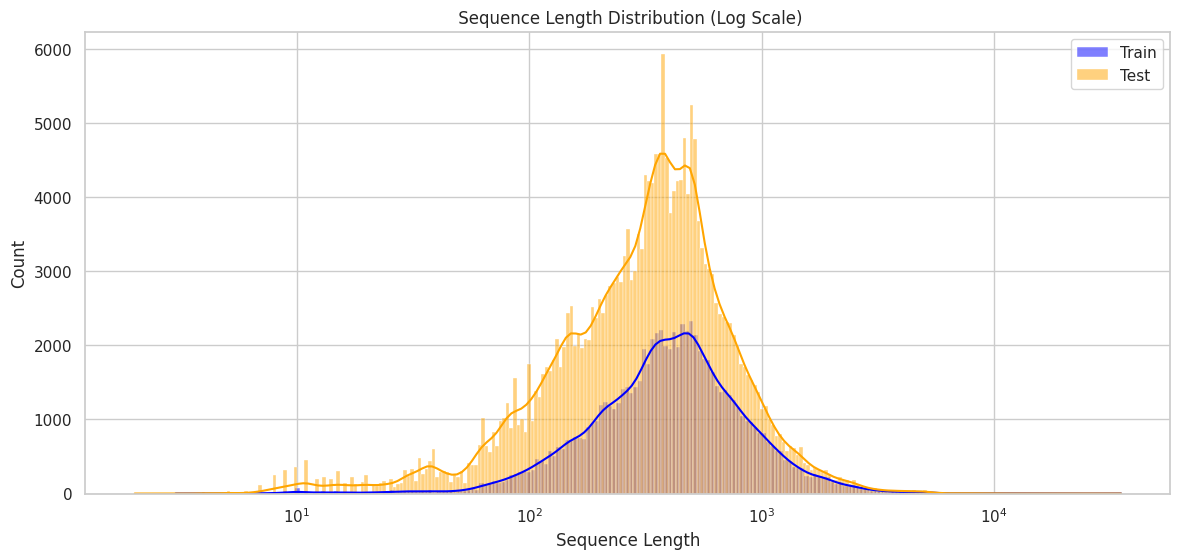

/tmp/ipykernel_12/1239687622.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_terms.values, y=top_terms.index, palette="viridis")


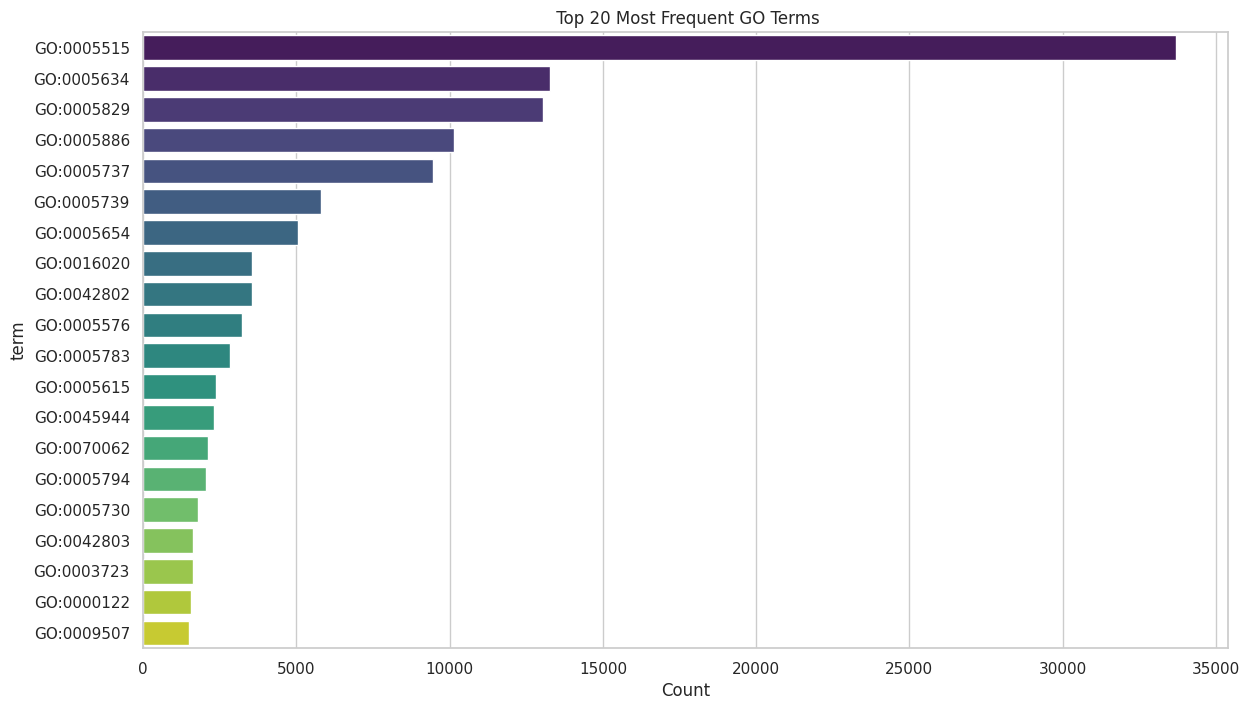

In [9]:
#  Load Data
print(" Loading sequences...")
train_seqs = {rec.id: str(rec.seq) for rec in SeqIO.parse(os.path.join(INPUT_DIR, "Train/train_sequences.fasta"), "fasta")}
test_seqs = {rec.id: str(rec.seq) for rec in SeqIO.parse(os.path.join(INPUT_DIR, "Test/testsuperset.fasta"), "fasta")}
train_terms_df = pd.read_csv(os.path.join(INPUT_DIR, "Train/train_terms.tsv"), sep="\t")

print(f" Train Sequences: {len(train_seqs):,}")
print(f" Test Sequences: {len(test_seqs):,}")
print(f" Train Annotations: {len(train_terms_df):,}")

# Plot Sequence Length Distribution
train_lens = [len(s) for s in train_seqs.values()]
test_lens = [len(s) for s in test_seqs.values()]

plt.figure(figsize=(14, 6))
sns.histplot(train_lens, color="blue", label="Train", kde=True, alpha=0.5, log_scale=True)
sns.histplot(test_lens, color="orange", label="Test", kde=True, alpha=0.5, log_scale=True)
plt.title(" Sequence Length Distribution (Log Scale)")
plt.xlabel("Sequence Length")
plt.legend()
plt.show()

#  Plot Top GO Terms
top_terms = train_terms_df['term'].value_counts().head(20)
plt.figure(figsize=(14, 8))
sns.barplot(x=top_terms.values, y=top_terms.index, palette="viridis")
plt.title(" Top 20 Most Frequent GO Terms")
plt.xlabel("Count")
plt.show()

##  Part 2: The Knowledge Graph (Gene Ontology)
Proteins functions are related! If a protein does X, and X is a subclass of Y, it also does Y. We need to parse the **Gene Ontology (GO)** graph to enforce these rules.

In [14]:
#  Parse OBO & Build Ancestors
def parse_obo(obo_file):
    terms = {}
    current_term = None
    with open(obo_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line == "[Term]":
                if current_term:
                    terms[current_term['id']] = current_term
                current_term = {'is_a': [], 'namespace': ''}
            elif line.startswith("id: "):
                current_term['id'] = line[4:]
            elif line.startswith("namespace: "):
                current_term['namespace'] = line[11:]
            elif line.startswith("is_a: "):
                current_term['is_a'].append(line[6:].split(' ! ')[0])
    if current_term:
        terms[current_term['id']] = current_term
    return terms

go_terms = parse_obo(os.path.join(INPUT_DIR, "Train/go-basic.obo"))
print(f" Parsed {len(go_terms):,} GO terms.")

# Build Ancestors (Transitive Closure)
ancestors = {}
for term_id in tqdm(go_terms, desc=" Building Graph"):
    queue = [term_id]
    visited = set()
    while queue:
        curr = queue.pop(0)
        if curr in visited: continue
        visited.add(curr)
        if curr in go_terms:
            queue.extend(go_terms[curr]['is_a'])
    ancestors[term_id] = list(visited)
with open(os.path.join(OUTPUT_LABELS_DIR, "ancestors.json"), "w") as f:
    json.dump(ancestors, f)
print(" Ancestor graph saved.")

 Parsed 48,101 GO terms.


 Building Graph:   0%|          | 0/48101 [00:00<?, ?it/s]

 Ancestor graph saved.


In [15]:
#  Build Label Matrices
used_terms = set(train_terms_df['term'].unique())
terms_MF = [t for t in used_terms if t in go_terms and go_terms[t]['namespace'] == 'molecular_function']
terms_BP = [t for t in used_terms if t in go_terms and go_terms[t]['namespace'] == 'biological_process']
terms_CC = [t for t in used_terms if t in go_terms and go_terms[t]['namespace'] == 'cellular_component']

term_maps = {
    'MF': {t: i for i, t in enumerate(terms_MF)},
    'BP': {t: i for i, t in enumerate(terms_BP)},
    'CC': {t: i for i, t in enumerate(terms_CC)}
}

with open(os.path.join(OUTPUT_LABELS_DIR, "maps.json"), "w") as f:
    json.dump(term_maps, f)

train_proteins = list(train_seqs.keys())
prot_map = {p: i for i, p in enumerate(train_proteins)}

for ns, terms_list in [('MF', terms_MF), ('BP', terms_BP), ('CC', terms_CC)]:
    term_map = term_maps[ns]
    df_ns = train_terms_df[train_terms_df['term'].isin(set(terms_list))]
    df_ns = df_ns[df_ns['EntryID'].isin(prot_map)]
    
    p_indices = df_ns['EntryID'].map(prot_map).values
    t_indices = df_ns['term'].map(term_map).values
    
    mat = sparse.coo_matrix((np.ones(len(p_indices)), (p_indices, t_indices)), 
                            shape=(len(train_proteins), len(terms_list)), dtype=np.int8)
    sparse.save_npz(os.path.join(OUTPUT_LABELS_DIR, f"labels_{ns}.npz"), mat.tocsr())
    print(f" Saved {ns} labels: {mat.shape}")

 Saved MF labels: (82404, 6616)
 Saved BP labels: (82404, 16858)
 Saved CC labels: (82404, 2651)


##  Part 3: Feature Engineering (Embeddings)
Here I will now extract rich features from protein sequences using **three** different models. This is the secret sauce! 
We define a generic embedding function to reuse for all models.

In [16]:
def embed_sequences(model_name, seq_dict, batch_size=16, max_len=1024, model_type="bert"):
    print(f" Loading {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
    
    #TPU compatibility: use xm.xla_device()
    if "xla" in str(device):
        import torch_xla.core.xla_model as xm
        dev = device
    else:
        dev = device
    
    if model_type == "t5":
        model = T5EncoderModel.from_pretrained(model_name).to(dev)
    else:
        model = AutoModel.from_pretrained(model_name).to(dev)
    model.eval()
    
    seqs = list(seq_dict.values())
    ids = list(seq_dict.keys())
    embeddings = []
    
    for i in tqdm(range(0, len(seqs), batch_size), desc=f"Embedding {model_name}"):
        batch_seqs = seqs[i:i+batch_size]

        # Space sequences
        batch_seqs = [" ".join(list(s)) for s in batch_seqs]

        inputs = tokenizer(batch_seqs, return_tensors="pt", padding=True,
                           truncation=True, max_length=max_len)
        inputs = {k: v.to(dev) for k, v in inputs.items()}
        
        with torch.no_grad():
            # TPU autocast wrapper (conditional)
            if "xla" in str(dev):
                import torch_xla.core.xla_model as xm
                outputs = model(**inputs)
                xm.mark_step()   # <<< IMPORTANT: forces TPU execution
            else:
                with torch.cuda.amp.autocast():
                    outputs = model(**inputs)

            # T5 pooling
            if model_type == "t5":
                emb = outputs.last_hidden_state.mean(dim=1)

            # BERT / ESM pooling
            else:
                attention_mask = inputs['attention_mask']
                last_hidden_state = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
                sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                emb = sum_embeddings / sum_mask
        
        embeddings.append(emb.cpu().numpy())
        
        # TPU step after each batch 
        if "xla" in str(dev):
            import torch_xla.core.xla_model as xm
            xm.mark_step()

    # Cleanup
    del model, tokenizer
    try:
        torch.cuda.empty_cache()
    except:
        pass
    gc.collect()

    return np.concatenate(embeddings), ids


In [ ]:
#  Model 1: ProtBERT
emb_bert_train, _ = embed_sequences("Rostlab/prot_bert", train_seqs, batch_size=32, model_type="bert")
np.save(os.path.join(EMBEDDINGS_DIR, "train_protbert.npy"), emb_bert_train)
del emb_bert_train

emb_bert_test, test_ids = embed_sequences("Rostlab/prot_bert", test_seqs, batch_size=32, model_type="bert")
np.save(os.path.join(EMBEDDINGS_DIR, "test_protbert.npy"), emb_bert_test)
np.save(os.path.join(EMBEDDINGS_DIR, "test_ids.npy"), test_ids)
del emb_bert_test
print(" ProtBERT embeddings saved.")

In [ ]:
#  Model 2: ESM-2 (150M)
emb_esm_train, _ = embed_sequences("facebook/esm2_t30_150M_UR50D", train_seqs, batch_size=32, model_type="esm")
np.save(os.path.join(EMBEDDINGS_DIR, "train_esm2.npy"), emb_esm_train)
del emb_esm_train

emb_esm_test, _ = embed_sequences("facebook/esm2_t30_150M_UR50D", test_seqs, batch_size=32, model_type="esm")
np.save(os.path.join(EMBEDDINGS_DIR, "test_esm2.npy"), emb_esm_test)
del emb_esm_test
print(" ESM-2 embeddings saved.")

In [ ]:
#  Model 3: ProtT5 (XL - Half Precision)
# Note: ProtT5 is large, we might need smaller batch size
emb_t5_train, _ = embed_sequences("Rostlab/prot_t5_xl_half_uniref50-enc", train_seqs, batch_size=16, model_type="t5")
np.save(os.path.join(EMBEDDINGS_DIR, "train_prott5.npy"), emb_t5_train)
del emb_t5_train

emb_t5_test, _ = embed_sequences("Rostlab/prot_t5_xl_half_uniref50-enc", test_seqs, batch_size=16, model_type="t5")
np.save(os.path.join(EMBEDDINGS_DIR, "test_prott5.npy"), emb_t5_test)
del emb_t5_test
print(" ProtT5 embeddings saved.")

##  Part 4: Training the Multi-Head Classifier

We will train a separate **Multi-Layer Perceptron (MLP)** for each embedding type. Each MLP has three heads: one for Molecular Function (MF), one for Biological Process (BP), and one for Cellular Component (CC).

In [ ]:
class MultiHeadMLP(nn.Module):
    def __init__(self, input_dim, proj_dim, out_dims):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.heads = nn.ModuleDict({
            ns: nn.Linear(proj_dim, dim) for ns, dim in out_dims.items()
        })
        
    def forward(self, x):
        x = self.proj(x)
        return {ns: head(x) for ns, head in self.heads.items()}


class ProteinDataset(Dataset):
    def __init__(self, embeddings, labels_dict):
        self.embeddings = embeddings
        self.labels = labels_dict
    def __len__(self): return len(self.embeddings)
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        lab = {ns: torch.tensor(self.labels[ns][idx], dtype=torch.float32) for ns in self.labels}
        return emb, lab



# TPU READY TRAINING (minimal edits only) 
def train_and_predict(model_name, train_emb_path, test_emb_path, out_dims, labels):
    print(f"\n Training on {model_name} embeddings...")

    # Load training embeddings
    train_emb = np.load(train_emb_path)
    input_dim = train_emb.shape[1]
    dataset = ProteinDataset(train_emb, labels)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

    # TPU ADDITION: detect TPU 
    using_tpu = ("xla" in str(device))
    if using_tpu:
        import torch_xla.core.xla_model as xm

    # Build model
    model = MultiHeadMLP(input_dim, 512, out_dims).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    #  AMP only on GPU 
    scaler = torch.cuda.amp.GradScaler(enabled=not using_tpu)

    # TRAINING LOOP
    for epoch in range(8):
        model.train()
        total_loss = 0

        for emb, lab in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False):
            emb = emb.to(device)
            lab = {ns: l.to(device) for ns, l in lab.items()}

            optimizer.zero_grad()

            # TPU: normal forward (no autocast) 
            if using_tpu:
                outputs = model(emb)
                loss = sum([criterion(outputs[ns], lab[ns]) for ns in lab])
                loss.backward()
                xm.optimizer_step(optimizer)      # <<< TPU-specific
                xm.mark_step()                    # <<< TPU commit
            else:
                # === GPU: autocast + scaler ===
                with torch.cuda.amp.autocast():
                    outputs = model(emb)
                    loss = sum([criterion(outputs[ns], lab[ns]) for ns in lab])

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item()

        print(f"  Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")

    # CLEANUP
    del dataset, dataloader, train_emb
    gc.collect()

    # INFERENCE
    print(f" Predicting with {model_name}...")
    test_emb = np.load(test_emb_path)

    model.eval()
    probs_all = {ns: [] for ns in out_dims}

    with torch.no_grad():
        for i in tqdm(range(0, len(test_emb), 256)):
            batch = torch.tensor(test_emb[i:i+256], dtype=torch.float32).to(device)

            if using_tpu:
                out = model(batch)
                xm.mark_step()      # <<< TPU flush
            else:
                out = model(batch)

            for ns in out:
                probs_all[ns].append(torch.sigmoid(out[ns]).cpu().numpy())

    return {ns: np.concatenate(p) for ns, p in probs_all.items()}


In [ ]:
# Load Labels & Maps
labels = {ns: sparse.load_npz(os.path.join(OUTPUT_LABELS_DIR, f"labels_{ns}.npz")).toarray() for ns in ['MF', 'BP', 'CC']}
with open(os.path.join(OUTPUT_LABELS_DIR, "maps.json")) as f: maps = json.load(f)
out_dims = {
    "MF": len(maps["mf_terms"]),
    "BP": len(maps["bp_terms"]),
    "CC": len(maps["cc_terms"]),
}


#  Train & Predict All Models
preds_bert = train_and_predict("ProtBERT", 
                               os.path.join(EMBEDDINGS_DIR, "train_protbert.npy"), 
                               os.path.join(EMBEDDINGS_DIR, "test_protbert.npy"), out_dims, labels)

preds_esm = train_and_predict("ESM2", 
                              os.path.join(EMBEDDINGS_DIR, "train_esm2.npy"), 
                              os.path.join(EMBEDDINGS_DIR, "test_esm2.npy"), out_dims, labels)

preds_t5 = train_and_predict("ProtT5", 
                             os.path.join(EMBEDDINGS_DIR, "train_prott5.npy"), 
                             os.path.join(EMBEDDINGS_DIR, "test_prott5.npy"), out_dims, labels)

##  Part 5: Ensemble & Submission
We average the probabilities from all three models. Then, we propagate the scores up the GO hierarchy using the **Max Rule** (if a child is predicted with score X, the parent must have score at least X).

In [ ]:
#  Ensemble Averaging
print(" Ensembling predictions...")
final_preds = {}
for ns in ['MF', 'BP', 'CC']:
    final_preds[ns] = (preds_bert[ns] + preds_esm[ns] + preds_t5[ns]) / 3.0

#  Propagate & Format
with open(os.path.join(OUTPUT_LABELS_DIR, "ancestors.json")) as f: ancestors = json.load(f)
rev_maps = {ns: {v: k for k, v in m.items()} for ns, m in maps.items()}
test_ids = np.load(os.path.join(EMBEDDINGS_DIR, "test_ids.npy"))

submission_lines = []
print(" Generating submission file...")

for i, pid in tqdm(enumerate(test_ids), total=len(test_ids)):
    prot_lines = []
    for ns in ['MF', 'BP', 'CC']:
        scores = final_preds[ns][i]
        # Optimization: Only consider terms with score > 0.001 to speed up propagation
        term_scores = {rev_maps[ns][idx]: float(s) for idx, s in enumerate(scores) if s > 0.001}
        
        # Propagation
        prop_scores = term_scores.copy()
        for t_id, score in term_scores.items():
            if t_id in ancestors:
                for anc in ancestors[t_id]:
                    prop_scores[anc] = max(prop_scores.get(anc, 0), score)
        
        for t_id, score in prop_scores.items():
            prot_lines.append((t_id, score))
            
    # Top 1500 per protein
    prot_lines.sort(key=lambda x: x[1], reverse=True)
    for t_id, score in prot_lines[:1500]:
        submission_lines.append(f"{pid}\t{t_id}\t{score:.3f}")

with open(os.path.join(WORKING_DIR, "submission.tsv"), "w") as f:
    f.write("\n".join(submission_lines))

print(" DONE! Submission saved to submission.tsv")

In [ ]:
#  Ensemble Averaging
print(" Ensembling predictions...")
final_preds = {
    "MF": (preds_bert["MF"] + preds_esm["MF"] + preds_t5["MF"]) / 3.0,
    "BP": (preds_bert["BP"] + preds_esm["BP"] + preds_t5["BP"]) / 3.0,
    "CC": (preds_bert["CC"] + preds_esm["CC"] + preds_t5["CC"]) / 3.0,
}

# Load ancestors
with open(os.path.join(OUTPUT_LABELS_DIR, "ancestors.json")) as f:
    ancestors = json.load(f)

# Correct reverse maps
rev_maps = {
    "MF": {i: go for i, go in enumerate(maps["mf_terms"])},
    "BP": {i: go for i, go in enumerate(maps["bp_terms"])},
    "CC": {i: go for i, go in enumerate(maps["cc_terms"])},
}

# Test IDs
test_ids = np.load(os.path.join(EMBEDDINGS_DIR, "test_ids.npy"))

submission_lines = []
print(" Generating submission file...")

for i, pid in tqdm(enumerate(test_ids), total=len(test_ids)):
    prot_lines = []

    for ns in ["MF", "BP", "CC"]:
        scores = final_preds[ns][i]

        # Only keep meaningful
        term_scores = {
            rev_maps[ns][idx]: float(s)
            for idx, s in enumerate(scores)
            if s > 0.001
        }

        # Propagation
        prop_scores = term_scores.copy()

        for go_id, score in term_scores.items():
            if go_id in ancestors:
                for anc in ancestors[go_id]:
                    prop_scores[anc] = max(prop_scores.get(anc, 0), score)

        # Add to list
        for go_id, score in prop_scores.items():
            prot_lines.append((go_id, score))

    # Top 1500
    prot_lines.sort(key=lambda x: x[1], reverse=True)
    for go_id, score in prot_lines[:1500]:
        submission_lines.append(f"{pid}\t{go_id}\t{score:.3f}")

# Save file
out_path = os.path.join(WORKING_DIR, "submission.tsv")
with open(out_path, "w") as f:
    f.write("\n".join(submission_lines))

print(" DONE! Submission saved to submission.tsv")
